#  Imports

In [1]:
%load_ext autoreload
%autoreload 2
from IPython.core.display import display, HTML
display(HTML("<style>.container {width:100% !important;}</style>"))

In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import albumentations as albu
import albumentations.pytorch as albu_pt
%matplotlib inline

import apex
import torch
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
import pytorch_tools as pt

from src.dataset import OpenCitiesDataset, OpenCitiesTestDataset, InriaTilesDataset
from src.augmentations import get_aug
from src.callbacks import ThrJaccardScore
from pytorch_tools.fit_wrapper.callbacks import SegmCutmix

In [3]:
import yaml
from src.utils import MODEL_FROM_NAME
from pytorch_tools.fit_wrapper.callbacks import Callback
from pytorch_tools.utils.misc import to_numpy

# Get dataloaders

In [4]:
SZ = 384
BS = 16
BUILDINGS_ONLY = True

aug = get_aug("medium", SZ)

val_aug = get_aug("val", SZ)

test_aug = get_aug("test", SZ)

val_dtst = OpenCitiesDataset(split="val", transform=val_aug, buildings_only=BUILDINGS_ONLY)
val_dtld = DataLoader(val_dtst, batch_size=BS, shuffle=False, num_workers=4, drop_last=True)
val_dtld_i = iter(val_dtld)

train_dtst = OpenCitiesDataset(split="train", transform=aug, buildings_only=BUILDINGS_ONLY)
train_dtld = DataLoader(train_dtst, batch_size=BS, shuffle=True, num_workers=8, drop_last=True)
train_dtld_i = iter(train_dtld)

test_dtst = OpenCitiesTestDataset(transform=test_aug)
test_dtld = DataLoader(test_dtst, batch_size=BS, shuffle=False, num_workers=8, drop_last=False)
test_dtld_i = iter(test_dtld)

In [5]:
val_dtst_inria = InriaTilesDataset(split="val", transform=val_aug)
val_dtst_inria = val_dtst_inria + val_dtst
val_dtld_inria = DataLoader(val_dtst_inria, batch_size=BS, shuffle=True, num_workers=8, drop_last=True)

train_dtst_inria = InriaTilesDataset(split="train", transform=aug)
train_dtld_inria = DataLoader(train_dtst_inria, batch_size=BS, shuffle=True, num_workers=8, drop_last=True)

In [6]:
class ToCudaLoader:
    def __init__(self, loader):
        self.loader = loader
        
    def __iter__(self):
        return ((img.cuda(), target.cuda()) for img, target in self.loader)
    
    def __len__(self):
        return len(self.loader)
    
val_dtld_gpu = ToCudaLoader(val_dtld)
train_dtld_gpu = ToCudaLoader(train_dtld)
val_dtld_inria_gpu = ToCudaLoader(val_dtld_inria)
train_dtld_inria_gpu = ToCudaLoader(train_dtld_inria)

In [7]:
len(train_dtst), len(val_dtst), len(test_dtst)

(10691, 1383, 11481)

In [8]:
len(train_dtst_inria), len(val_dtst_inria)

(26195, 2608)

In [9]:
img, mask = train_dtst[1]
img.shape, mask.shape

(torch.Size([3, 384, 384]), torch.Size([1, 384, 384]))

In [10]:
img, mask = train_dtst_inria[1]
img.shape, mask.shape

(torch.Size([3, 384, 384]), torch.Size([1, 384, 384]))

In [11]:
# plt.imshow(mask[2])

In [12]:
test_dtst[0][0].shape, test_dtst[0][1].shape

((1024, 1024, 3), torch.Size([3, 1024, 1024]))

In [45]:
# val_dtld_i = iter(val_dtld_inria)
val_dtld_i = iter(val_dtld)

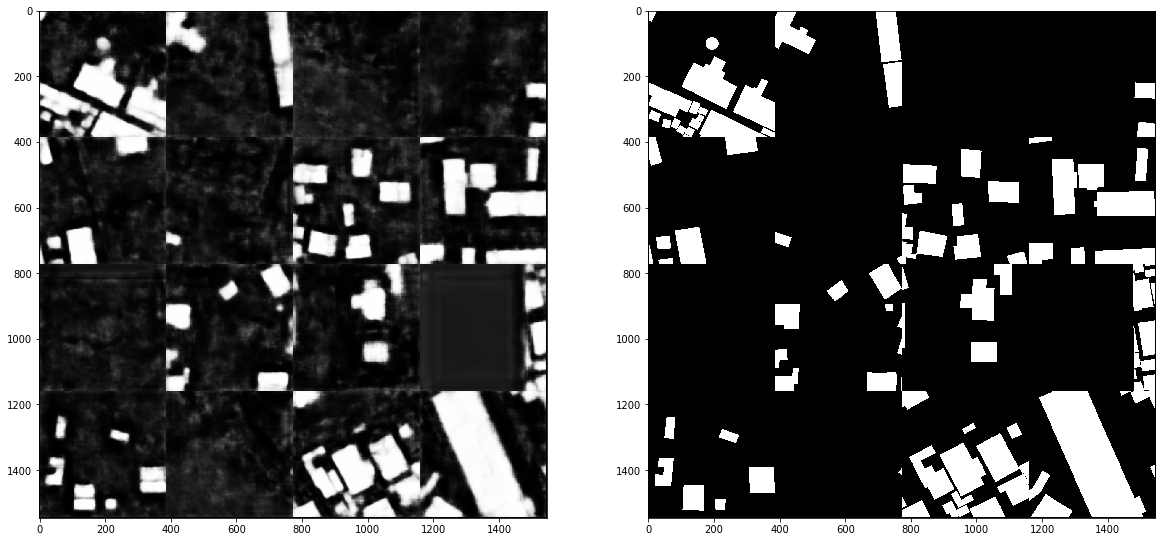

In [63]:
# batch = next(val_dtld_i)
imgs, masks = next(val_dtld_i)
# imgs, masks = SegmCutmix(1, 1).cutmix(imgs, masks) # test cutmix
# (_, imgs, _), (_, masks, _) = next(test_dtld_i), next(test_dtld_i) 
preds = model(imgs.cuda()).cpu().detach()
imgs = preds.sigmoid()
imgs_grid = make_grid(imgs, nrow=4).transpose(0,2)#.transpose(0,1)
masks_grid = make_grid(masks, nrow=4).transpose(0,2)#.transpose(0,1)
fig, axes = plt.subplots(ncols=2, figsize=(20, 10))
axes[0].imshow(imgs_grid)
axes[1].imshow(masks_grid);

# Model training

In [16]:
from bloodaxe_models import get_model as get_ba_model

In [51]:
# model = pt.segmentation_models.DeepLabV3(
#     'se_resnet50', output_stride=16, num_classes=1
# ).cuda()
# model = pt.segmentation_models.Unet(
#     'se_resnet50', num_classes=1
# ).cuda()
# model = get_ba_model("hrnet34_unet64").cuda()
# model = get_ba_model("resnet34_fpncat128").cuda()
model = pt.segmentation_models.SegmentationFPN('se_resnet50', num_classes=1, merge_policy="cat").cuda()
# model = pt.segmentation_models.SegmentationBiFPN('se_resnet50', num_fpn_layers=1, merge_policy="cat").cuda()
# optim = torch.optim.Adam(model.parameters(), lr=3e-4, weight_decay=1e-5)
optim = apex.optimizers.FusedNovoGrad(model.parameters(), weight_decay=1e-5, set_grad_none=False)
model, optim = apex.amp.initialize(model, optim, verbosity=0, loss_scale=2048)
# freeze encoder
# for p in model.encoder.parameters():
#     p.requires_grad = False
pt.utils.misc.count_parameters(model)

(28646384, 28646384)

In [52]:
# log_path = "logs/2.deeplab_nov_warmup_20200212_171523/"
# model.load_state_dict(torch.load(log_path + 'model.chpn')["state_dict"], strict=False)

In [53]:
loss = pt.losses.CrossEntropyLoss(mode="binary").cuda()
# loss = pt.losses.JaccardLoss(mode="binary").cuda()
# loss = 0.5 * pt.losses.CrossEntropyLoss(mode="binary").cuda() + 0.5 * loss
# loss = 0.5 * loss + 0.5 * pt.losses.BinaryFocalLoss().cuda() 
# loss = pt.losses.BinaryFocalLoss().cuda() 
# loss = pt.losses.LovaszLoss().cuda() + 4 * pt.losses.BinaryFocalLoss().cuda() 

In [54]:
bce_metric = pt.losses.CrossEntropyLoss(mode="binary").cuda()
bce_metric.name = "BCE"

In [55]:
runner = pt.fit_wrapper.Runner(
    model, 
    optim, 
    criterion=BinaryHinge(), #loss,
    callbacks=[
#         pt.fit_wrapper.callbacks.Timer(),
        pt.fit_wrapper.callbacks.ConsoleLogger(), 
#         PatchTarget(), # needed for bloodaxe models
#         pt.fit_wrapper.callbacks.ReduceLROnPlateau(10),
#         pt.fit_wrapper.callbacks.FileLogger('/tmp/')
    ],
    metrics=[pt.metrics.JaccardScore(mode="binary"), bce_metric, ThrJaccardScore()],
)

In [56]:
# freeze encoder
for p in model.encoder.parameters():
    p.requires_grad = False

In [57]:
# imgs, masks = next(iter(val_dtld_gpu))
# pred = model(imgs)
# imgs.dtype, masks.dtype, imgs.shape, masks.shape, pred.shape

In [58]:
runner.fit(val_dtld_gpu, epochs=30) #, val_loader=val_dtld_inria_gpu, epochs=1)

Epoch  1/30. training: 87it [00:06, 14.10it/s, BCE=0.644, Jaccard=0.164, Loss=0.8716, ThrJaccard@0.5=0.169]            
Epoch  2/30. training: 87it [00:06, 14.32it/s, BCE=0.572, Jaccard=0.174, Loss=0.6916, ThrJaccard@0.5=0.187]            
Epoch  3/30. training: 87it [00:06, 14.06it/s, BCE=0.505, Jaccard=0.183, Loss=0.5169, ThrJaccard@0.5=0.178]            
Epoch  4/30. training: 87it [00:06, 14.29it/s, BCE=0.468, Jaccard=0.186, Loss=0.4379, ThrJaccard@0.5=0.157]            
Epoch  5/30. training: 87it [00:06, 14.14it/s, BCE=0.449, Jaccard=0.189, Loss=0.4053, ThrJaccard@0.5=0.154]            
Epoch  6/30. training: 87it [00:06, 14.32it/s, BCE=0.435, Jaccard=0.195, Loss=0.3877, ThrJaccard@0.5=0.172]            
Epoch  7/30. training: 87it [00:06, 14.08it/s, BCE=0.424, Jaccard=0.202, Loss=0.3744, ThrJaccard@0.5=0.206]            
Epoch  8/30. training: 87it [00:06, 14.06it/s, BCE=0.415, Jaccard=0.212, Loss=0.3626, ThrJaccard@0.5=0.247]            
Epoch  9/30. training: 87it [00:06, 14.0

In [59]:
for p in model.parameters():
    p.requires_grad = True

In [60]:
runner.fit(val_dtld_gpu, epochs=30) #, val_loader=val_dtld_inria_gpu, epochs=1)

Epoch  1/30. training: 87it [00:11,  7.89it/s, BCE=0.299, Jaccard=0.360, Loss=0.2423, ThrJaccard@0.5=0.583]            
Epoch  2/30. training: 87it [00:10,  7.94it/s, BCE=0.266, Jaccard=0.396, Loss=0.1937, ThrJaccard@0.5=0.659]            
Epoch  3/30. training: 87it [00:11,  7.89it/s, BCE=0.247, Jaccard=0.419, Loss=0.1621, ThrJaccard@0.5=0.710]            
Epoch  4/30. training: 87it [00:11,  7.79it/s, BCE=0.232, Jaccard=0.437, Loss=0.1396, ThrJaccard@0.5=0.747]            
Epoch  5/30. training: 87it [00:11,  7.88it/s, BCE=0.220, Jaccard=0.453, Loss=0.1227, ThrJaccard@0.5=0.777]            
Epoch  6/30. training: 87it [00:11,  7.89it/s, BCE=0.193, Jaccard=0.496, Loss=0.1099, ThrJaccard@0.5=0.799]            
Epoch  7/30. training: 87it [00:11,  7.85it/s, BCE=0.181, Jaccard=0.515, Loss=0.1020, ThrJaccard@0.5=0.814]            
Epoch  8/30. training: 87it [00:11,  7.83it/s, BCE=0.172, Jaccard=0.530, Loss=0.0967, ThrJaccard@0.5=0.823]            
Epoch  9/30. training: 87it [00:11,  7.8

# Results examination

In [81]:
# log_path = "logs/fpn_sm_cat_seresnet50_20200208_190143/"
# log_path = "logs/fpn_sm_20200205_165954/" # 0.71 on LB. 0.67 on local per image
# log_path = "logs/deeplab_small_dilation_seresnet50_20200209_112059/" # 0.72 on local val
# log_path = "logs/fpn_nov_bce_dice_seresnet50_20200209_235106/"
log_path = "logs/3.segm_fpn_nov_hinge_seresnet50_warmup_20200213_160637/"
config = yaml.load(open(log_path + "config.yaml"))
model = MODEL_FROM_NAME[config["segm_arch"]](config["arch"], **config.get("model_params", {})).cuda()
print("model loaded")
model.load_state_dict(torch.load(log_path + 'model.chpn')["state_dict"], strict=False)

model loaded


<All keys matched successfully>

In [82]:
# torch.onnx.export(model, torch.ones(1, 3, 256, 256).cuda(), "model.onnx")

In [83]:
model = apex.amp.initialize(model, verbosity=0)

In [84]:
val_dtld = DataLoader(val_dtst, batch_size=1, shuffle=False, num_workers=2, drop_last=True)
val_dtld_gpu = ToCudaLoader(val_dtld)

In [85]:
# val_dtld = DataLoader(val_dtst, batch_size=16, shuffle=False, num_workers=4, drop_last=True)
# val_dtld_gpu = ToCudaLoader(val_dtld)

In [86]:
class ResultsHist(Callback):
    """Saves all values of loss"""
    def __init__(self):
        super().__init__()
        self.res = []
        
    def on_batch_end(self):
        data, target = self.state.input
        output = self.state.output
        loss = self.state.metrics[0](output, target)
        self.res.append(to_numpy(loss))
    
    def on_loader_end(self):
        self.res = np.array(self.res)
        
class PredSaver(Callback):
    """Saves best and worse predicts"""
    def __init__(self, best_thr=0.9, worst_thr=0.2, filter_empty=True):
        super().__init__()
        self.best_img = []
        self.best_target = []
        self.best_preds = []
        self.best_metric = []
        
        self.worst_img = []
        self.worst_target = []
        self.worst_preds = []
        self.worst_metric = []
        
        self.best_thr = best_thr
        self.worst_thr = worst_thr
        self.filter_empty = filter_empty
        
    def on_batch_end(self):
        data, target = self.state.input
        output = self.state.output
        metric = self.state.metrics[0](output, target)
        metric = to_numpy(metric)
        if metric > self.best_thr:
            if self.filter_empty and to_numpy(target).sum() == 0:
                return 
            self.best_img.append(to_numpy(data))
            self.best_target.append(to_numpy(target))
            self.best_preds.append(to_numpy(output))
            self.best_metric.append(metric)
        
        if metric < self.worst_thr:
            self.worst_img.append(to_numpy(data))
            self.worst_target.append(to_numpy(target))
            self.worst_preds.append(to_numpy(output))
            self.worst_metric.append(metric)
#         self.res.append(pt.utils.misc.to_numpy(metric))
    
    def on_loader_end(self):
        if len(self.worst_img) > 0:
            self.worst_img = np.swapaxes(np.array(self.worst_img).squeeze(), 1, 3)
            self.worst_img = np.swapaxes(self.worst_img, 1, 2)
            self.worst_target = np.array(self.worst_target).squeeze()
            self.worst_preds = np.array(self.worst_preds).squeeze()
            self.worst_metric = np.array(self.worst_metric)
        
        if len(self.best_img) > 0:
            self.best_img = np.swapaxes(np.array(self.best_img).squeeze(), 1, 3)
            self.best_img = np.swapaxes(self.best_img, 1, 2)
            self.best_target = np.array(self.best_target).squeeze()
            self.best_preds = np.array(self.best_preds).squeeze()
            self.best_metric = np.array(self.best_metric)
    
def sigmoid(x):
    return 1/(1 + np.exp(-x)) 

In [87]:
hinge_metric = pt.losses.BinaryHinge()
hinge_metric.name = "Hinge"

In [88]:
loss = pt.losses.JaccardLoss()
results_hist = ResultsHist()
pred_saver = PredSaver(worst_thr=0.1, best_thr=0.4)
runner = pt.fit_wrapper.Runner(
    model, 
    None, 
    criterion=loss,
    callbacks=[
        pt.fit_wrapper.callbacks.ConsoleLogger(),
        results_hist,
        pred_saver,
    ],
    metrics=[
        hinge_metric,
#         bce_metric,
        pt.metrics.JaccardScore(mode="binary"),
        ThrJaccardScore(thr=0.4),
#         ThrJaccardScore(thr=0.3),
#         ThrJaccardScore(thr=0.4),
    ]
)
runner.evaluate(val_dtld_gpu)

Epoch  1/1. validating: 1384it [00:46, 29.98it/s, Hinge=0.170, Jaccard=0.330, Loss=0.6705, ThrJaccard@0.4=0.651]              


(0.6704639211480202,
 [0.16958499508759567, 0.3295360788519798, 0.6509861313426141])

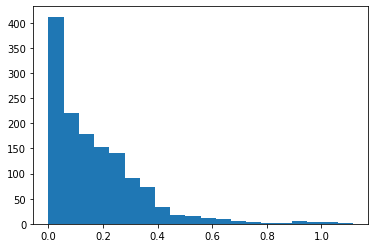

In [89]:
plt.hist(results_hist.res, bins=20);

In [90]:
len(pred_saver.worst_preds), len(pred_saver.best_preds)

(587, 104)

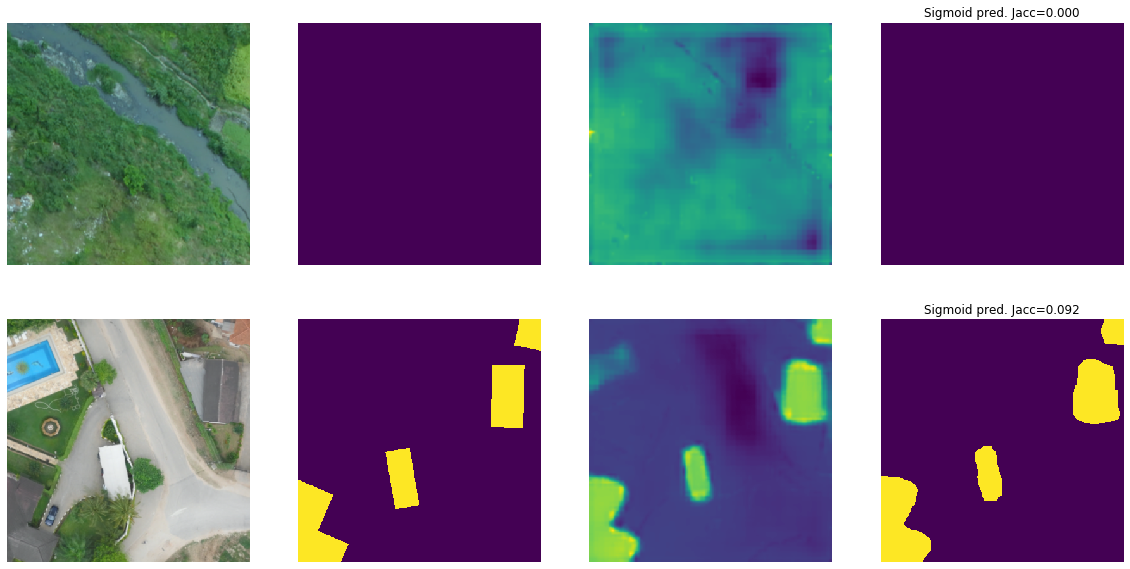

In [111]:
# Worst predictions
N_ROW = 2
fig, axes = plt.subplots(N_ROW, 4, figsize=(20, 10))
for i in axes:
    for j in i:
        j.axis('off')
for i in range(N_ROW):
    N = np.random.randint(0, len(pred_saver.worst_preds))
    img = pred_saver.worst_img[N] * (0.229, 0.224, 0.225) + (0.485, 0.456, 0.406)
    axes[i][0].imshow((img * 255).astype(np.uint8))
    axes[i][1].imshow(pred_saver.worst_target[N])
    axes[i][2].imshow(pred_saver.worst_preds[N])
    axes[i][3].imshow(sigmoid(pred_saver.worst_preds[N]) > 0.5)
#     axes[i][3].imshow(pred_saver.worst_preds[N] > 0.5)
    axes[i][3].set_title(f"Sigmoid pred. Jacc={pred_saver.worst_metric[N]:.03f}")
    

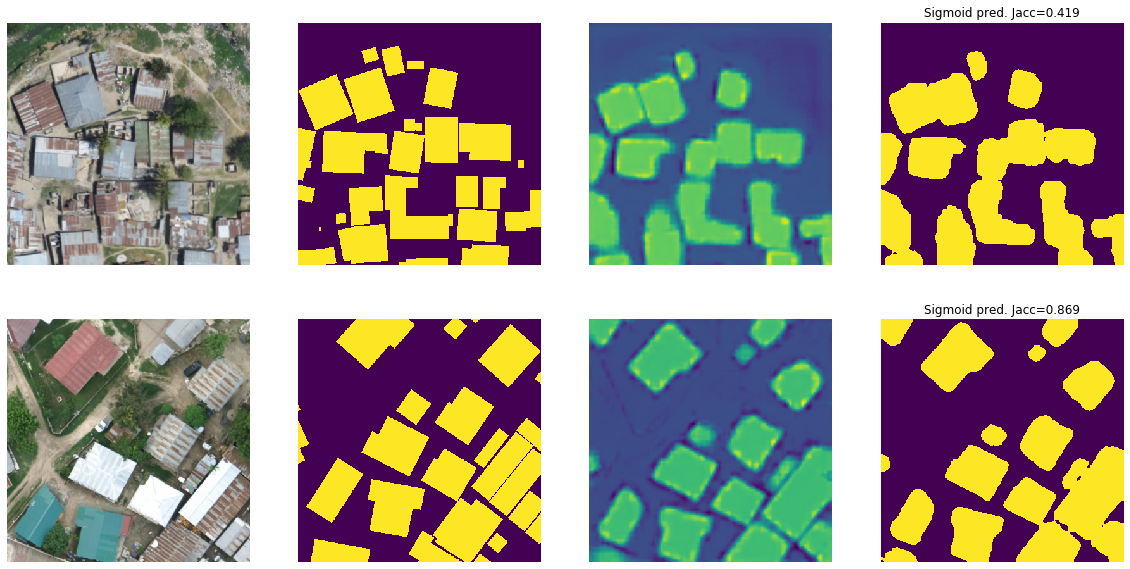

In [80]:
# Best predictions
N_ROW = 2
fig, axes = plt.subplots(N_ROW, 4, figsize=(20, 10))
for i in axes:
    for j in i:
        j.axis('off')
for i in range(N_ROW):
    N = np.random.randint(0, len(pred_saver.best_preds))
    img = pred_saver.best_img[N] * (0.229, 0.224, 0.225) + (0.485, 0.456, 0.406)
    img = (img * 255).astype(np.uint8)
    pred = pred_saver.best_preds[N]
    axes[i][0].imshow(img)
    axes[i][1].imshow(pred_saver.best_target[N])
    axes[i][2].imshow(pred)
    axes[i][3].imshow(sigmoid(pred_saver.best_preds[N]) > 0.5)
    axes[i][3].set_title(f"Sigmoid pred. Jacc={pred_saver.best_metric[N]:.03f}")
    

In [50]:
pred_saver.best_target[N].min()

0.0

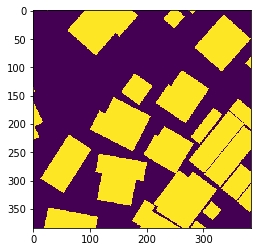

In [48]:
plt.imshow(pred_saver.best_target[N])

# Test CRF

In [87]:
import src.convcrf as convcrf

In [114]:
def _get_simple_unary(batched=False):
    unary1 = np.zeros((10, 10), dtype=np.float32)
    unary1[:, [0, -1]] = unary1[[0, -1], :] = 1

    unary2 = np.zeros((10, 10), dtype=np.float32)
    unary2[4:7, 4:7] = 1

    unary = np.vstack([unary1.flat, unary2.flat])
    unary = (unary + 1) / (np.sum(unary, axis=0) + 2)

    if batched:
        unary = unary.reshape(tuple([1]) + unary)

    return unary

def _get_simple_img(batched=False):

    img = np.zeros((10, 10, 3), dtype=np.uint8)
    img[2:8, 2:8, :] = 255

    if batched:
        img = img.reshape(tuple([1]) + img)

    return img


In [112]:
convcrf.get_default_conf()

{'filter_size': 11,
 'blur': 4,
 'merge': True,
 'norm': 'none',
 'weight': 'vector',
 'unary_weight': 1,
 'weight_init': 0.2,
 'trainable': False,
 'convcomp': False,
 'logsoftmax': True,
 'softmax': True,
 'final_softmax': False,
 'pos_feats': {'sdims': 3, 'compat': 3},
 'col_feats': {'sdims': 80, 'schan': 13, 'compat': 10, 'use_bias': False},
 'trainable_bias': False,
 'pyinn': False}

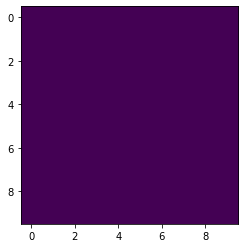

In [129]:
conf = convcrf.get_test_conf()
conf["final_softmax"] = False
conf["pyinn"] = False
tcrf = convcrf.GaussCRF(conf, [10, 10], None).cuda()

unary = _get_simple_unary()
img = _get_simple_img()

img = np.transpose(img, [2, 0, 1])
img_torch = torch.Tensor(img).cuda()

unary_var = torch.Tensor(unary).cuda()
unary_var = unary_var.view(2, 10, 10)
img_var = torch.Tensor(img).cuda()
img_var = img_var.view(1, *img_var.shape)

prediction = tcrf.forward(unary_var, img_var).cpu().data.numpy()
res = np.argmax(prediction, axis=0)
# import scipy.misc
# scipy.misc.imsave("out.png", res)
# d.addPairwiseBilateral(2, 2, img, 3)
plt.imshow(res[1])

In [132]:
res[0]

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [88]:
conf = convcrf.get_default_conf()
crf = convcrf.GaussCRF(conf, [384, 384], 2)

In [92]:
unary.shape

torch.Size([1, 1, 384, 384])

In [89]:
unary = torch.from_numpy(pred).view(1, 1, 384, 384)
img_tensor = torch.from_numpy(np.transpose(img, [2, 0, 1])).view(1, 3, 384, 384)
res = crf.forward(unary, img_tensor)

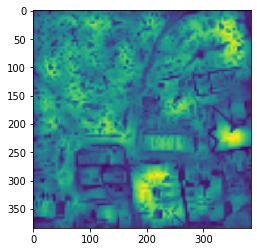

In [90]:
plt.imshow(res.numpy().squeeze()[1] / 255)

# Looking for bugs

# Create Binary Hinge loss

In [23]:
def binary_hinge(pred, target, margin=1):
    # pred : BS X HW
    # target : BS x HW
    pred = pred.view(pred.size(0), -1)
    target = target.view(target.size(0), -1)
    target = 2 * target - 1  # [target == 0] = -1
    hinge = torch.nn.functional.relu(margin - pred * target).mean(1)
    return hinge.mean() # reduction == mean

from pytorch_tools.losses.base import Loss

class BinaryHinge(Loss):
    def forward(self, pred, target):
        assert pred.size(1) == 1
        return binary_hinge(pred, target)

# BinaryHinge()(PR, TR)